In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thesis/Dataset (S/validation/labels/0566.png
/kaggle/input/thesis/Dataset (S/validation/labels/0133.png
/kaggle/input/thesis/Dataset (S/validation/labels/0006.png
/kaggle/input/thesis/Dataset (S/validation/labels/0516.png
/kaggle/input/thesis/Dataset (S/validation/labels/0003.png
/kaggle/input/thesis/Dataset (S/validation/labels/0217.png
/kaggle/input/thesis/Dataset (S/validation/labels/0816.png
/kaggle/input/thesis/Dataset (S/validation/labels/0337.png
/kaggle/input/thesis/Dataset (S/validation/labels/0835.png
/kaggle/input/thesis/Dataset (S/validation/labels/0096.png
/kaggle/input/thesis/Dataset (S/validation/labels/0451.png
/kaggle/input/thesis/Dataset (S/validation/labels/0301.png
/kaggle/input/thesis/Dataset (S/validation/labels/0947.png
/kaggle/input/thesis/Dataset (S/validation/labels/0405.png
/kaggle/input/thesis/Dataset (S/validation/labels/0341.png
/kaggle/input/thesis/Dataset (S/validation/labels/0208.png
/kaggle/input/thesis/Dataset (S/validation/labels/0369.p

In [2]:
# === Cell 1: Cài & import thư viện cơ bản ===
!pip install -q segmentation-models-pytorch albumentations timm

import os, cv2, gc, random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Device:", DEVICE)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Device: cuda


In [3]:
# === Cell 2: Load dataset & tạo train/val pairs ===
ROOT = "/kaggle/input/thesis"
for root, dirs, files in os.walk(ROOT):
    if root.endswith("/train/images"):
        DATA_DIR = root.rsplit("/train/images", 1)[0]
print("Using DATA_DIR:", DATA_DIR)

def get_pairs(split):
    img_dir = os.path.join(DATA_DIR, split, "images")
    mask_dir = os.path.join(DATA_DIR, split, "labels")
    imgs = sorted(glob(os.path.join(img_dir, "*")))
    pairs = [(i, os.path.join(mask_dir, os.path.basename(i))) for i in imgs]
    print(f"{split}: {len(pairs)} samples")
    return pairs

train_pairs = get_pairs("train")
val_pairs = get_pairs("validation")


Using DATA_DIR: /kaggle/input/thesis/Dataset (S
train: 810 samples
validation: 200 samples


In [4]:
# === Cell 3: Define loss & metrics ===
def dice_coef(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum((2,3))
    union = pred.sum((2,3)) + target.sum((2,3))
    return ((2*inter + smooth)/(union + smooth)).mean().item()

def iou_coef(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum((2,3))
    union = (pred + target - pred * target).sum((2,3))
    return ((inter + smooth)/(union + smooth)).mean().item()

def bce_dice_loss(pred, target, smooth=1e-5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred_sig = torch.sigmoid(pred)
    inter = (pred_sig * target).sum((2,3))
    union = pred_sig.sum((2,3)) + target.sum((2,3))
    dice = 1 - ((2*inter + smooth)/(union + smooth))
    return bce + dice.mean()


Train batches: 405 | Val batches: 100


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_19/4149448560.py:27: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=40, sigma=5, alpha_affine=10, p=0.3),


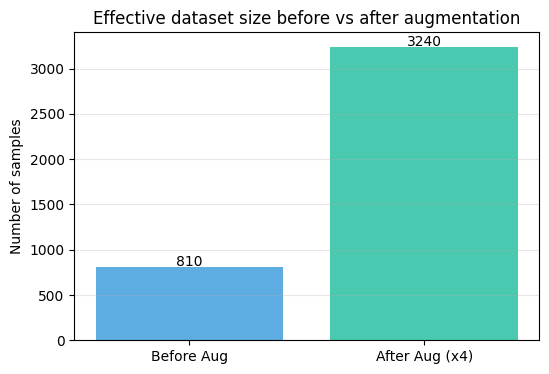

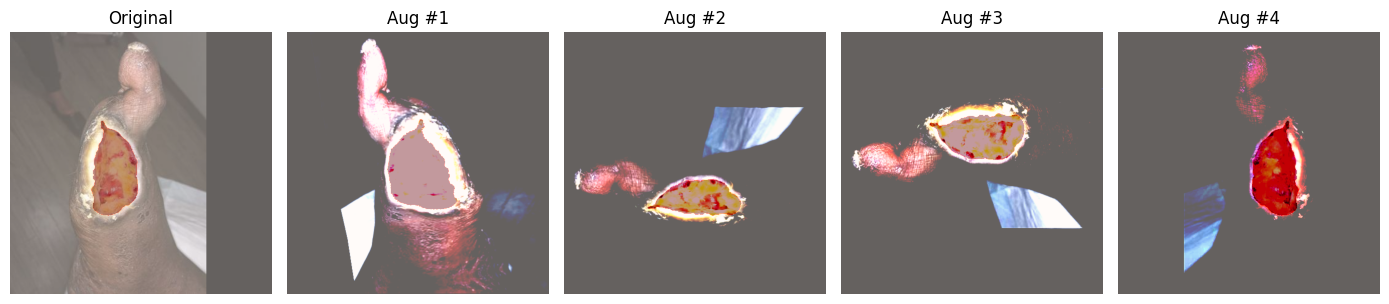

In [5]:
# === Cell 4: Dataset with Advanced Augmentation (rotation + color + distortion) ===
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import random, cv2

CFG_IMG = 512
CFG_BATCH = 2

# ✅ Advanced training augmentation
train_aug = A.Compose([
    # --- Hình học ---
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.4),
    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.05, rotate_limit=180,
        border_mode=cv2.BORDER_REFLECT, p=0.5
    ),

    # --- Màu sắc / ánh sáng ---
    A.RandomBrightnessContrast(p=0.4),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.4),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),

    # --- Biến dạng mô mềm / texture ---
    A.ElasticTransform(alpha=40, sigma=5, alpha_affine=10, p=0.3),
    A.GridDistortion(p=0.2),
    A.GaussianBlur(blur_limit=3, p=0.2),

    # --- Chuẩn hóa ---
    A.Resize(CFG_IMG, CFG_IMG),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ✅ Validation augmentation (chỉ resize + normalize)
val_aug = A.Compose([
    A.Resize(CFG_IMG, CFG_IMG),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ✅ Dataset class
class DFUSegAug(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        ip, mp = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(ip), cv2.COLOR_BGR2RGB)
        mask = (cv2.imread(mp, cv2.IMREAD_GRAYSCALE) > 0).astype("float32")
        aug = self.transform(image=img, mask=mask)
        return aug["image"], aug["mask"].unsqueeze(0)

# ✅ DataLoaders
train_ds = DFUSegAug(train_pairs, transform=train_aug)
val_ds = DFUSegAug(val_pairs, transform=val_aug)
train_loader = DataLoader(train_ds, batch_size=CFG_BATCH, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=CFG_BATCH, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

# --- Plot so sánh số lượng ảnh (vật lý không đổi, nhưng hiệu quả nhân đôi) ---
aug_factor = 4  # giả định mỗi ảnh sinh 4 biến thể ngẫu nhiên
before = len(train_pairs)
after_eff = before * aug_factor

plt.figure(figsize=(6,4))
plt.bar(["Before Aug", f"After Aug (x{aug_factor})"], [before, after_eff], color=["#5DADE2", "#48C9B0"])
plt.title("Effective dataset size before vs after augmentation")
plt.ylabel("Number of samples")
for i, v in enumerate([before, after_eff]): plt.text(i, v + before*0.02, str(v), ha="center")
plt.grid(axis="y", alpha=0.3)
plt.show()

# --- Plot trực quan: 1 ảnh gốc + 4 ảnh augmented ---
idx = random.randint(0, len(train_pairs)-1)
ip, mp = train_pairs[idx]
orig = cv2.cvtColor(cv2.imread(ip), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(14,4))
plt.subplot(1,5,1)
plt.imshow(orig); plt.imshow(mask, cmap="Reds", alpha=0.4)
plt.title("Original"); plt.axis("off")

for i in range(4):
    aug = train_aug(image=orig, mask=mask)
    img_aug = aug["image"].permute(1,2,0).cpu().numpy()
    mask_aug = aug["mask"].cpu().numpy()
    plt.subplot(1,5,i+2)
    plt.imshow(np.clip(img_aug,0,1))
    plt.imshow(mask_aug, cmap="Reds", alpha=0.4)
    plt.title(f"Aug #{i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
# === Cell 5: Training functions (đầy đủ train/val Dice + IoU) ===
def train_one_epoch(model, loader, opt):
    model.train(); tl, td, ti = 0,0,0
    for x,y in tqdm(loader, leave=False):
        x,y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad(); o = model(x)
        l = bce_dice_loss(o,y); l.backward(); opt.step()
        tl += l.item(); td += dice_coef(o,y); ti += iou_coef(o,y)
    n = len(loader); return tl/n, td/n, ti/n

@torch.no_grad()
def valid_one_epoch(model, loader):
    model.eval(); vl, vd, vi = 0,0,0
    for x,y in tqdm(loader, leave=False):
        x,y = x.to(DEVICE), y.to(DEVICE)
        o = model(x); l = bce_dice_loss(o,y)
        vl += l.item(); vd += dice_coef(o,y); vi += iou_coef(o,y)
    n = len(loader); return vl/n, vd/n, vi/n

def train_model(model, name, epochs=60, lr=1e-4):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best, hist = 0, {"train_dice":[], "val_dice":[], "train_loss":[], "val_loss":[], "train_iou":[], "val_iou":[]}
    for e in range(1, epochs+1):
        print(f"\nEpoch {e}/{epochs}")
        trl, trd, tri = train_one_epoch(model, train_loader, opt)
        vl, vd, vi = valid_one_epoch(model, val_loader)
        hist["train_loss"].append(trl); hist["val_loss"].append(vl)
        hist["train_dice"].append(trd); hist["val_dice"].append(vd)
        hist["train_iou"].append(tri); hist["val_iou"].append(vi)
        print(f"Loss {trl:.3f}/{vl:.3f} | Dice {trd:.3f}/{vd:.3f} | IoU {tri:.3f}/{vi:.3f}")
        if vd > best: best = vd; torch.save(model.state_dict(), f"{name}_best.pth")
    print(f"✅ Done. Best Val Dice: {best:.4f}")
    return hist


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


Epoch 1/60


Loss 0.926/0.591 | Dice 0.529/0.710 | IoU 0.410/0.594

Epoch 2/60


Loss 0.464/0.318 | Dice 0.698/0.753 | IoU 0.579/0.649

Epoch 3/60


Loss 0.334/0.299 | Dice 0.740/0.756 | IoU 0.628/0.650

Epoch 4/60


Loss 0.289/0.269 | Dice 0.759/0.768 | IoU 0.654/0.672

Epoch 5/60


Loss 0.255/0.239 | Dice 0.787/0.794 | IoU 0.684/0.700

Epoch 6/60


Loss 0.260/0.234 | Dice 0.777/0.795 | IoU 0.675/0.704

Epoch 7/60


Loss 0.248/0.220 | Dice 0.789/0.805 | IoU 0.689/0.717

Epoch 8/60


Loss 0.228/0.225 | Dice 0.807/0.804 | IoU 0.709/0.710

Epoch 9/60


Loss 0.234/0.241 | Dice 0.800/0.788 | IoU 0.702/0.703

Epoch 10/60


Loss 0.228/0.218 | Dice 0.804/0.806 | IoU 0.706/0.718

Epoch 11/60


Loss 0.219/0.226 | Dice 0.812/0.801 | IoU 0.717/0.713

Epoch 12/60


Loss 0.220/0.202 | Dice 0.808/0.817 | IoU 0.713/0.729

Epoch 13/60


Loss 0.206/0.193 | Dice 0.826/0.828 | IoU 0.735/0.742

Epoch 14/60


Loss 0.201/0.210 | Dice 0.825/0.816 | IoU 0.734/0.730

Epoch 15/60


Loss 0.206/0.203 | Dice 0.822/0.816 | IoU 0.731/0.732

Epoch 16/60


Loss 0.203/0.206 | Dice 0.822/0.824 | IoU 0.730/0.738

Epoch 17/60


Loss 0.200/0.205 | Dice 0.827/0.822 | IoU 0.737/0.735

Epoch 18/60


Loss 0.204/0.193 | Dice 0.821/0.829 | IoU 0.731/0.744

Epoch 19/60


Loss 0.198/0.189 | Dice 0.830/0.829 | IoU 0.740/0.745

Epoch 20/60


Loss 0.199/0.198 | Dice 0.824/0.827 | IoU 0.733/0.739

Epoch 21/60


Loss 0.195/0.187 | Dice 0.828/0.835 | IoU 0.739/0.754

Epoch 22/60


Loss 0.191/0.198 | Dice 0.831/0.821 | IoU 0.745/0.738

Epoch 23/60


Loss 0.201/0.196 | Dice 0.827/0.824 | IoU 0.735/0.739

Epoch 24/60


Loss 0.190/0.192 | Dice 0.835/0.827 | IoU 0.747/0.743

Epoch 25/60


Loss 0.192/0.179 | Dice 0.831/0.838 | IoU 0.745/0.757

Epoch 26/60


Loss 0.190/0.182 | Dice 0.831/0.834 | IoU 0.743/0.754

Epoch 27/60


Loss 0.200/0.189 | Dice 0.824/0.828 | IoU 0.735/0.743

Epoch 28/60


Loss 0.184/0.198 | Dice 0.838/0.824 | IoU 0.752/0.742

Epoch 29/60


Loss 0.195/0.194 | Dice 0.831/0.824 | IoU 0.745/0.739

Epoch 30/60


Loss 0.185/0.187 | Dice 0.836/0.831 | IoU 0.751/0.751

Epoch 31/60


Loss 0.178/0.175 | Dice 0.842/0.841 | IoU 0.756/0.763

Epoch 32/60


Loss 0.178/0.175 | Dice 0.841/0.842 | IoU 0.756/0.762

Epoch 33/60


Loss 0.167/0.179 | Dice 0.852/0.838 | IoU 0.769/0.760

Epoch 34/60


Loss 0.175/0.186 | Dice 0.846/0.832 | IoU 0.762/0.748

Epoch 35/60


Loss 0.175/0.187 | Dice 0.847/0.835 | IoU 0.763/0.752

Epoch 36/60


Loss 0.176/0.191 | Dice 0.844/0.833 | IoU 0.761/0.751

Epoch 37/60


Loss 0.182/0.189 | Dice 0.839/0.828 | IoU 0.754/0.748

Epoch 38/60


Loss 0.177/0.184 | Dice 0.844/0.838 | IoU 0.761/0.757

Epoch 39/60


Loss 0.179/0.178 | Dice 0.843/0.845 | IoU 0.757/0.766

Epoch 40/60


Loss 0.173/0.190 | Dice 0.849/0.830 | IoU 0.766/0.747

Epoch 41/60


Loss 0.182/0.175 | Dice 0.841/0.841 | IoU 0.757/0.762

Epoch 42/60


Loss 0.164/0.181 | Dice 0.857/0.836 | IoU 0.776/0.757

Epoch 43/60


Loss 0.164/0.167 | Dice 0.856/0.853 | IoU 0.777/0.777

Epoch 44/60


Loss 0.166/0.176 | Dice 0.853/0.840 | IoU 0.773/0.762

Epoch 45/60


Loss 0.170/0.189 | Dice 0.853/0.841 | IoU 0.771/0.761

Epoch 46/60


Loss 0.173/0.189 | Dice 0.846/0.836 | IoU 0.763/0.755

Epoch 47/60


Loss 0.182/0.172 | Dice 0.840/0.849 | IoU 0.756/0.773

Epoch 48/60


Loss 0.166/0.173 | Dice 0.856/0.843 | IoU 0.775/0.765

Epoch 49/60


Loss 0.165/0.171 | Dice 0.855/0.844 | IoU 0.774/0.768

Epoch 50/60


Loss 0.167/0.175 | Dice 0.854/0.841 | IoU 0.772/0.762

Epoch 51/60


Loss 0.162/0.177 | Dice 0.857/0.840 | IoU 0.776/0.761

Epoch 52/60


Loss 0.172/0.181 | Dice 0.849/0.839 | IoU 0.768/0.760

Epoch 53/60


Loss 0.161/0.173 | Dice 0.856/0.843 | IoU 0.776/0.765

Epoch 54/60


Loss 0.162/0.172 | Dice 0.855/0.843 | IoU 0.775/0.767

Epoch 55/60


Loss 0.164/0.172 | Dice 0.856/0.843 | IoU 0.775/0.767

Epoch 56/60


Loss 0.163/0.167 | Dice 0.856/0.848 | IoU 0.777/0.772

Epoch 57/60


Loss 0.159/0.169 | Dice 0.857/0.855 | IoU 0.779/0.778

Epoch 58/60


Loss 0.161/0.170 | Dice 0.858/0.851 | IoU 0.778/0.776

Epoch 59/60


Loss 0.160/0.168 | Dice 0.857/0.848 | IoU 0.778/0.772

Epoch 60/60


Loss 0.164/0.165 | Dice 0.855/0.851 | IoU 0.775/0.777
✅ Done. Best Val Dice: 0.8547


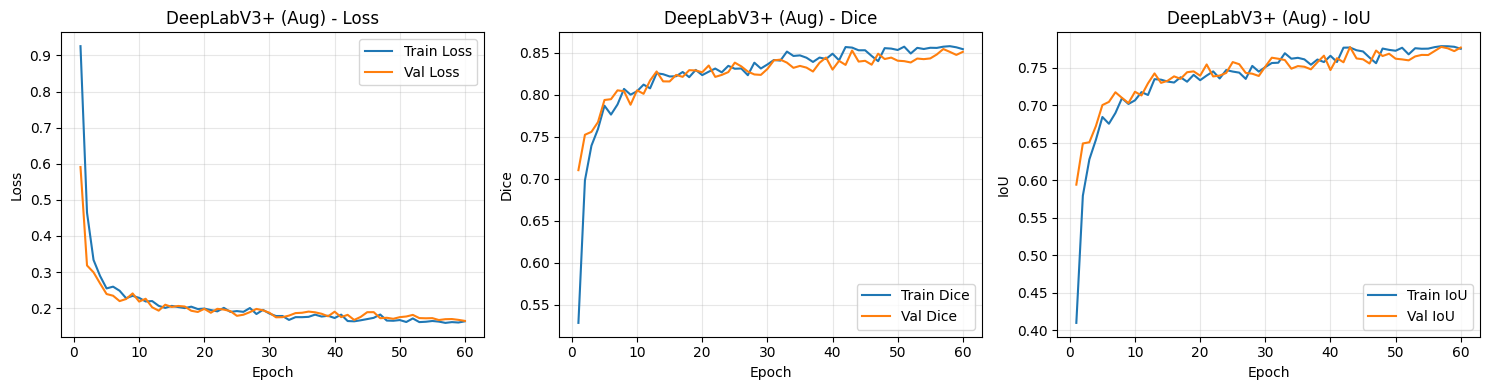

In [7]:
# Cell 6: Train DeepLabV3+ with augmentation + plot train/val Loss, Dice, IoU

import gc
import matplotlib.pyplot as plt

CFG_EPOCHS = 60
CFG_LR = 1e-4

torch.cuda.empty_cache()
gc.collect()

# Khởi tạo DeepLabV3+ với encoder ResNet50 (chuẩn, đủ mạnh)
deeplab_aug = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)
deeplab_aug.to(DEVICE)

# Huấn luyện với train_loader / val_loader (đã augmentation ở Cell 4)
hist_deeplab_aug = train_model(
    deeplab_aug,
    name="DeepLabV3Plus_Aug",
    epochs=CFG_EPOCHS,
    lr=CFG_LR
)

# Plot
epochs = range(1, len(hist_deeplab_aug["train_loss"]) + 1)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(epochs, hist_deeplab_aug["train_loss"], label="Train Loss")
plt.plot(epochs, hist_deeplab_aug["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("DeepLabV3+ (Aug) - Loss")
plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1,3,2)
plt.plot(epochs, hist_deeplab_aug["train_dice"], label="Train Dice")
plt.plot(epochs, hist_deeplab_aug["val_dice"], label="Val Dice")
plt.xlabel("Epoch"); plt.ylabel("Dice")
plt.title("DeepLabV3+ (Aug) - Dice")
plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1,3,3)
plt.plot(epochs, hist_deeplab_aug["train_iou"], label="Train IoU")
plt.plot(epochs, hist_deeplab_aug["val_iou"], label="Val IoU")
plt.xlabel("Epoch"); plt.ylabel("IoU")
plt.title("DeepLabV3+ (Aug) - IoU")
plt.legend(); plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
